# Building custom integrator in OpenMM

Our goal is to build a custom integrator that can do Brownian dynamics and/or Langevin dynamics with translationally invariant active noise. This requires defining a per particle variable that is the diffusion coefficient.

In [31]:
import numpy as np
import openmm as mm
from openmm.app import *
from openmmtools import respa, utils
from simtk import unit
from pathlib import Path

from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt

import polychrom
import os, sys
import polychrom
from polychrom import simulation, starting_conformations, forces, forcekits
import openmm
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
import h5py

from openmmtools.integrators import PrettyPrintableIntegrator
import time

In [40]:
#What is the monomer diffusion coefficient?
collision_rate = 2.0 * (1 / unit.picosecond)
conlen = 1.0 * unit.nanometer
mass = 100 * unit.amu
temperature = 300
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
kT = kB * temperature * unit.kelvin
kT / (mass * collision_rate)

Quantity(value=12.471693927229861, unit=picosecond*joule/(mole*dalton))

In [4]:
#one way to create a custom integrator is to subclass
class ActiveBrownianIntegrator(utils.RestorableOpenMMObject, PrettyPrintableIntegrator, mm.CustomIntegrator):
    """ Taking inspiration from custom integrators available in openmmtools. They created a
    PrettyPrintableIntegrator class that will print out the computation steps of the integrator.
    
    They also developed a RestorableOpenMMObject: Normally, a custom OpenMM object loses its specific class 
    (and all its methods) when it is copied or deserialized from its XML representation.
    Class interfaces inheriting from this can be restored through the method
    ``restore_interface()``. Also, this class extend the copying functions
    to copy also Python attributes.
    
    """
    def __init__(self, timestep, collision_rate, *args, **kwargs):
        super(ActiveBrownianIntegrator, self).__init__(timestep, *args, **kwargs)
        #define variables
        self.addUpdateContextState()
        self.addGlobalVariable("zeta", collision_rate *(1 / unit.picosecond))
        self.addGlobalVariable("l", 1.0 * unit.nanometer) #length scale of simulation
        self.addPerDofVariable("D", 0.0)
        #update context state before adding any computations
        self.addComputePerDof("D", "f1") #assumes diffusion coefficient is in force group 1
        #WARNING: D is in units of force. To convert to units of diffusion coefficient, 
        #multiply by a length scale and divide by friction coefficient
        #self.addComputePerDof("xi", "zeta*m") #friction coefficient in correct units
        #Euler Marayama update to position
        self.addComputePerDof("x", "x + sqrt(2*(D*l/(zeta*m)) * dt)*gaussian")
        #self.addComputePerDof("v", "v + f0/(zeta*m) + sqrt(2*(D*l/(zeta*m))/dt)*gaussian")
        #self.addConstrainVelocities()
        #self.addComputePerDof("x", "x + v*dt")
        #self.addConstrainPositions()
        

## Simple Verlet Integrator using force groups

Confirmed that including force groups in custom integrator, where force is nonzero for some subset of particles, works.

In [5]:
#one way to create a custom integrator is to subclass
class VerletIntegrator(utils.RestorableOpenMMObject, PrettyPrintableIntegrator, mm.CustomIntegrator):
    """ Taking inspiration from custom integrators available in openmmtools. They created a
    PrettyPrintableIntegrator class that will print out the computation steps of the integrator.
    
    They also developed a RestorableOpenMMObject: Normally, a custom OpenMM object loses its specific class 
    (and all its methods) when it is copied or deserialized from its XML representation.
    Class interfaces inheriting from this can be restored through the method
    ``restore_interface()``. Also, this class extend the copying functions
    to copy also Python attributes.
    
    """
    def __init__(self, timestep=1.0 * unit.femtoseconds):
        super(VerletIntegrator, self).__init__(timestep)
        self.addPerDofVariable("x1", 0)        
        self.addUpdateContextState()
        self.addComputePerDof("v", "v+0.5*dt*f1/m")
        self.addComputePerDof("x", "x+dt*v")
        self.addComputePerDof("x1", "x")
        self.addConstrainPositions()
        self.addComputePerDof("v", "v+0.5*dt*f1/m+(x-x1)/dt")
        self.addConstrainVelocities()

In [6]:
def diffusion_constant_force(sim_object, D, name="diffusion", force_group=None):
    """ Force to be added to polychrom.forces module.
    Defines a constant external force that varies per particle. Constant force experienced
    by each particle in array D.
    
    Parameters
    ----------
    D : np.ndarray (N,)
        Diffusion coefficients of N particles in units of kT/(mass * collision_rate)
    """
    fakeExternal = mm.CustomExternalForce("fx * (x+y+z)")
    fakeExternal.name = name
    if force_group:
        if type(force_group) != int:
            raise TypeError("Force group should be an integer 0, 1, 2, etc.")
        fakeExternal.setForceGroup(force_group)
    fakeExternal.addPerParticleParameter("fx")
    for i in range(sim_object.N):
        fakeExternal.addParticle(i, [D[i] * sim_object.kT / sim_object.conlen])
        
    return fakeExternal
        

### Try adding per DOF variables directly in integrator

Instead of using the hacky trick where we define a constant external force and use it inside the custom integrator, let's try creating a perDOF variable for the diffusion coefficient with the correct units and direclty using inside the integrator.

In [15]:
class VerletIntegratorDOF(utils.RestorableOpenMMObject, PrettyPrintableIntegrator, mm.CustomIntegrator):
    """ Taking inspiration from custom integrators available in openmmtools. They created a
    PrettyPrintableIntegrator class that will print out the computation steps of the integrator.
    
    They also developed a RestorableOpenMMObject: Normally, a custom OpenMM object loses its specific class 
    (and all its methods) when it is copied or deserialized from its XML representation.
    Class interfaces inheriting from this can be restored through the method
    ``restore_interface()``. Also, this class extend the copying functions
    to copy also Python attributes.
    
    """
    def __init__(self, timestep, particleD):
        super(VerletIntegratorDOF, self).__init__(timestep)
        self.addPerDofVariable("x1", 0)
        self.addPerDofVariable("D", 0)
        self.setPerDofVariableByName("D", particleD)
        self.addUpdateContextState()
        self.addComputePerDof("v", "v+0.5*dt*D/m")
        self.addComputePerDof("x", "x+dt*v")
        self.addComputePerDof("x1", "x")
        self.addConstrainPositions()
        self.addComputePerDof("v", "v+0.5*dt*D/m+(x-x1)/dt")
        self.addConstrainVelocities()

In [16]:
N=10
D = np.zeros((N, 3))
D[5:, :] = 10.0
particleD = unit.Quantity(D,  kT / conlen)
particleD

Quantity(value=array([[    0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ],
       [24943.38785446, 24943.38785446, 24943.38785446],
       [24943.38785446, 24943.38785446, 24943.38785446],
       [24943.38785446, 24943.38785446, 24943.38785446],
       [24943.38785446, 24943.38785446, 24943.38785446],
       [24943.38785446, 24943.38785446, 24943.38785446]]), unit=joule/(nanometer*mole))

In [18]:
N=10
D = np.zeros(N,)

In [21]:
reporter = HDF5Reporter(folder="simulations/test_integrator", max_data_length=100, overwrite=True)
collision_rate = 0.01 * (1 / unit.picosecond)
integrator = VerletIntegratorDOF(40 * unit.femtosecond, particleD)
integrator.pretty_print()
sim = simulation.Simulation(
    platform="CUDA", 
    integrator=integrator,
    error_tol=0.003,
    timestep=40,
    GPU="0",
    collision_rate=0.01,
    N=N,
    save_decimals=2,
    PBCbox=[50, 50, 50],
    verbose=True,
    reporters=[reporter],
)
#sim.masses = np.zeros(sim.N, dtype=float) + sim.kwargs["mass"]
#for mass in sim.masses:
#    sim.system.addParticle(mass)
    
polymer = starting_conformations.grow_cubic(N, 50)
sim.set_data(polymer, center=True)
sim.set_velocities(np.zeros((N, 3)))
#sim.context = mm.Context(sim.system, sim.integrator, sim.platform, sim.properties)
#sim.init_positions()
#sim.init_velocities()
# loads a polymer, puts a center of mass at zero
#sim.add_force()
sim.add_force(diffusion_constant_force(sim, D, force_group=1))

INFO:root:Using the provided integrator object


step      0 : allow forces to update the context state
step      1 : v <- v+0.5*dt*D/m
step      2 : x <- x+dt*v
step      3 : x1 <- x
step      4 : constrain positions
step      5 : v <- v+0.5*dt*D/m+(x-x1)/dt
step      6 : constrain velocities


In [22]:
ntimesteps = 25
for _ in range(ntimesteps):  # Do 10 blocks
    sim.do_block(1)  # Of 100 timesteps each. Data is saved automatically. 
sim.print_stats()  # In the end, print very simple statistics

reporter.dump_data()  # always need to run in the end to dump the block cache to the disk


INFO:root:applying forces
INFO:root:adding force diffusion 0
INFO:root:Particles loaded. Potential energy is 0.000000
INFO:root:block    0 pos[1]=[-0.2 -0.7 -1.2] dr=0.00 t=0.0ps kin=0.00 pot=0.00 Rg=39.285 SPS=3254 
INFO:root:block    1 pos[1]=[-0.2 -0.7 -1.2] dr=0.00 t=0.1ps kin=0.01 pot=0.00 Rg=39.285 SPS=3522 
INFO:root:block    2 pos[1]=[-0.2 -0.7 -1.2] dr=0.00 t=0.1ps kin=0.03 pot=0.00 Rg=39.285 SPS=3722 
INFO:root:block    3 pos[1]=[-0.2 -0.7 -1.2] dr=0.00 t=0.2ps kin=0.05 pot=0.00 Rg=39.285 SPS=3762 
INFO:root:block    4 pos[1]=[-0.2 -0.7 -1.2] dr=0.00 t=0.2ps kin=0.07 pot=0.00 Rg=39.284 SPS=3666 
INFO:root:block    5 pos[1]=[-0.2 -0.7 -1.2] dr=0.01 t=0.2ps kin=0.11 pot=0.00 Rg=39.284 SPS=3927 
INFO:root:block    6 pos[1]=[-0.2 -0.7 -1.2] dr=0.00 t=0.3ps kin=0.15 pot=0.00 Rg=39.283 SPS=3866 
INFO:root:block    7 pos[1]=[-0.2 -0.7 -1.2] dr=0.00 t=0.3ps kin=0.19 pot=0.00 Rg=39.283 SPS=3484 
INFO:root:block    8 pos[1]=[-0.2 -0.7 -1.2] dr=0.01 t=0.4ps kin=0.24 pot=0.00 Rg=39.282 S


 Statistics: number of particles: 10

Statistics for particle position
     mean position is:  [0.06235847 0.06235847 0.06235847]   Rg =  39.262366352505914
     median bond size is  1.0000009700749766
     three shortest/longest (<10)/ bonds are  [0.99998549 0.99998607 0.99998927]    [1.00001014 1.00001429 1.13845282]
     95 percentile of distance to center is:    1.5640558479562199
     density of closest 95% monomers is:    0.5927590956107475
     density of the 5% closest to CoM monomers is:    0.5317003805556563
     min/median/mean/max coordinates are: 
     x: -0.20, -0.08, 0.06, 0.80
     y: -0.70, -0.14, 0.06, 1.42
     z: -1.20, -0.08, 0.06, 0.92

Statistics for velocities:
     mean kinetic energy is:  1.8707540890844787 should be: 1.5
     fastest particles are (in kT):  [3.74150818 3.74150818 3.74150818 3.74150818 3.74150818]

Statistics for the system:
     Forces are:  ['diffusion']

Potential Energy Ep =  0.0


In [ ]:
sim.system.getForces()

In [23]:
starting_pos = load_hdf5_file("simulations/test_integrator/starting_conformation_0.h5")['pos']
#check that only members of force group 1 moved
data = list_URIs("simulations/test_integrator")
dxs = []
prev_pos = starting_pos
for conformation in data:
    pos = load_URI(conformation)['pos']
    dx_squared = np.sum((pos - starting_pos)**2, axis=-1)
    dxs.append(dx_squared)

(25, 10)


Text(0, 0.5, 'MSD')

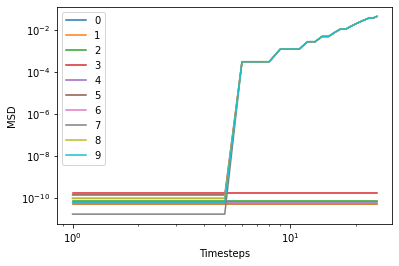

In [24]:
dxs = np.array(dxs)
print(dxs.shape)
times = np.arange(1, ntimesteps + 1)
for i in range(dxs.shape[1]):
    plt.plot(times, dxs[:, i], label=f'{i}')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Timesteps')
plt.ylabel('MSD')

## Debugging strategies

- [x] First check whether force groups even work. just do a Velocity Verlet integrator and only apply forces to some group.
- [ ] Check BrownianIntegrator on vanilla polychrom simulations and make sure parameter choices work and don't produce NaNs
- [ ] Try implementing Langevin integrator as written in openmmtools but with force groups?

## Brownian integrators

Now we know that per particle DOFs work as we intend! Our next task is to figure out how to construct a Brownian dynamics integrator that does not produce NaNs. Things to try:

- [x] Use built in brownian integrator on a polychrom simulation with self avoidance and confinement to figure out what parameters produce sensible results. The answer is use collision rate = 2 picoseconds and timestep of 40 femtoseconds. Can probably go larger too.
- [x] Use built in brownian integrator on toy system in this notebook to see what trajectories look like. See if I can reproduce this with my own vanilla Brownian integrator.
- [x] Try a simple integrator with the built in variable gaussian to see if it introduces noise properly into the system

In [25]:
reporter = HDF5Reporter(folder="simulations/test_integrator", max_data_length=100, overwrite=True)
collision_rate = 0.01 * (1 / unit.picosecond)
sim = simulation.Simulation(
    platform="CUDA", 
    integrator="brownian",
    error_tol=0.003,
    timestep=40,
    GPU="0",
    collision_rate=0.01,
    N=N,
    save_decimals=2,
    PBCbox=[50, 50, 50],
    verbose=True,
    reporters=[reporter],
)
  
polymer = starting_conformations.grow_cubic(N, 50)
sim.set_data(polymer, center=True)
sim.set_velocities(np.zeros((N, 3)))
sim.add_force(diffusion_constant_force(sim, D, force_group=1))

ntimesteps = 25
for _ in range(ntimesteps):  # Do 10 blocks
    sim.do_block(1)  # Of 100 timesteps each. Data is saved automatically. 
sim.print_stats()  # In the end, print very simple statistics

reporter.dump_data()  # always need to run in the end to dump the block cache to the disk

In [12]:
def plot_MSD():
    starting_pos = load_hdf5_file("simulations/test_integrator/starting_conformation_0.h5")['pos']
    #check that only members of force group 1 moved
    data = list_URIs("simulations/test_integrator")
    dxs = []
    prev_pos = starting_pos
    for conformation in data:
        pos = load_URI(conformation)['pos']
        dx_squared = np.sum((pos - starting_pos)**2, axis=-1)
        dxs.append(dx_squared)

    dxs = np.array(dxs)
    print(dxs.shape)
    times = np.arange(1, ntimesteps + 1)
    for i in range(dxs.shape[1]):
        plt.plot(times, dxs[:, i], label=f'{i}')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Timesteps')
    plt.ylabel('MSD')

(25, 10)


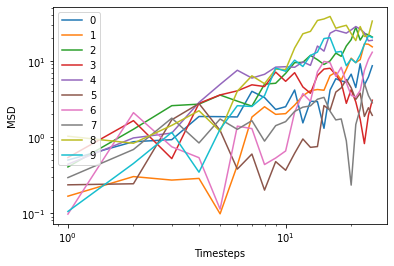

In [29]:
plot_MSD()

In [14]:
class BrownianIntegrator(utils.RestorableOpenMMObject, PrettyPrintableIntegrator, mm.CustomIntegrator):
    """ Brownian motion integrator
    """
    def __init__(self, timestep, collision_rate, particleD):
        super(BrownianIntegrator, self).__init__(timestep)
        self.addGlobalVariable("zeta", collision_rate *(1 / unit.picosecond))
        self.addPerDofVariable("D", 0)
        self.addPerDofVariable("x1", 0)
        self.setPerDofVariableByName("D", particleD)
        self.addUpdateContextState()
        self.addComputePerDof("x1", "x + (f/(zeta*m))*dt + sqrt(2*D*dt)*gaussian")
        self.addComputePerDof("v", "(x1 - x)/dt")
        self.addComputePerDof("x", "x1")
        #self.addConstrainVelocities()
        self.addConstrainPositions()

In [3]:
N=10
D = np.ones((N, 3))
D[5:, :] = 10.0
particleD = unit.Quantity(D,  kT / (mass * collision_rate))
particleD

NameError: name 'kT' is not defined

In [28]:
reporter = HDF5Reporter(folder="simulations/test_integrator", max_data_length=100, overwrite=True)
collision_rate = 2.0 * (1 / unit.picosecond)
integrator = BrownianIntegrator(40*unit.femtosecond, collision_rate, particleD)
sim = simulation.Simulation(
    platform="CUDA", 
    integrator=integrator,
    error_tol=0.003,
    timestep=170,
    GPU="0",
    collision_rate=0.01,
    N=N,
    save_decimals=2,
    PBCbox=[50, 50, 50],
    verbose=True,
    reporters=[reporter],
)
  
polymer = starting_conformations.grow_cubic(N, 50)
sim.set_data(polymer, center=True)
sim.set_velocities(np.zeros((N, 3)))
sim.add_force(diffusion_constant_force(sim, np.zeros(N), force_group=None))

ntimesteps = 1000
for _ in range(ntimesteps):  # Do 10 blocks
    sim.do_block(100)  # Of 100 timesteps each. Data is saved automatically. 
sim.print_stats()  # In the end, print very simple statistics

reporter.dump_data()  # always need to run in the end to dump the block cache to the disk

INFO:root:Using the provided integrator object
INFO:root:applying forces
INFO:root:adding force diffusion 0
INFO:root:Particles loaded. Potential energy is 0.000000
INFO:root:block    0 pos[1]=[-12.5 21.5 -4.8] dr=99.65 t=4.0ps kin=30441.66 pot=0.00 Rg=25.354 SPS=79709 
INFO:root:block    1 pos[1]=[-17.2 42.8 18.4] dr=189.48 t=8.0ps kin=53428.71 pot=0.00 Rg=26.001 SPS=89699 
INFO:root:block    2 pos[1]=[-52.0 26.0 84.9] dr=198.49 t=12.0ps kin=53945.71 pot=0.00 Rg=22.045 SPS=89949 
INFO:root:block    3 pos[1]=[-96.3 13.2 156.7] dr=216.31 t=16.0ps kin=74883.59 pot=0.00 Rg=25.699 SPS=89488 
INFO:root:block    4 pos[1]=[-143.7 -9.9 246.3] dr=260.24 t=20.0ps kin=95730.65 pot=0.00 Rg=20.448 SPS=88768 
INFO:root:block    5 pos[1]=[-190.5 33.5 350.6] dr=298.06 t=24.0ps kin=133602.11 pot=0.00 Rg=24.014 SPS=90472 
INFO:root:block    6 pos[1]=[-275.6 100.9 496.7] dr=334.41 t=28.0ps kin=121840.15 pot=0.00 Rg=24.809 SPS=89260 
INFO:root:block    7 pos[1]=[-360.5 170.8 687.4] dr=314.57 t=32.0ps kin=

INFO:root:block   71 pos[1]=[9578.4 8376.7 4225.0] dr=964.94 t=288.0ps kin=1156183.35 pot=0.00 Rg=23.187 SPS=88562 
INFO:root:block   72 pos[1]=[9725.3 8372.6 4226.2] dr=941.38 t=292.0ps kin=1083710.35 pot=0.00 Rg=25.589 SPS=92959 
INFO:root:block   73 pos[1]=[9874.0 8359.4 4230.8] dr=917.79 t=296.0ps kin=1051053.13 pot=0.00 Rg=21.309 SPS=93644 
INFO:root:block   74 pos[1]=[10048.8 8348.2 4227.3] dr=908.77 t=300.0ps kin=1027558.33 pot=0.00 Rg=27.626 SPS=93790 
INFO:root:block   75 pos[1]=[10217.3 8326.7 4179.6] dr=919.29 t=304.0ps kin=1097061.83 pot=0.00 Rg=21.857 SPS=93895 
INFO:root:block   76 pos[1]=[10342.3 8285.2 4100.9] dr=940.52 t=308.0ps kin=1107790.60 pot=0.00 Rg=23.967 SPS=93248 
INFO:root:block   77 pos[1]=[10399.0 8260.5 4011.8] dr=923.19 t=312.0ps kin=1139030.96 pot=0.00 Rg=21.372 SPS=93021 
INFO:root:block   78 pos[1]=[10508.0 8276.9 3944.3] dr=934.29 t=316.0ps kin=1159566.02 pot=0.00 Rg=20.168 SPS=92061 
INFO:root:block   79 pos[1]=[10658.5 8291.8 3866.4] dr=971.82 t=320

INFO:root:block  140 pos[1]=[16206.1 23031.1 -15628.8] dr=1352.82 t=564.0ps kin=2335985.63 pot=0.00 Rg=22.892 SPS=97068 
INFO:root:block  141 pos[1]=[16346.0 23316.8 -15977.5] dr=1369.26 t=568.0ps kin=2324602.36 pot=0.00 Rg=26.360 SPS=99133 
INFO:root:block  142 pos[1]=[16513.0 23624.8 -16338.0] dr=1365.52 t=572.0ps kin=2383939.62 pot=0.00 Rg=22.606 SPS=99485 
INFO:root:block  143 pos[1]=[16698.5 23952.9 -16717.8] dr=1416.81 t=576.0ps kin=2620282.29 pot=0.00 Rg=22.400 SPS=100079 
INFO:root:block  144 pos[1]=[16897.2 24274.4 -17145.3] dr=1469.38 t=580.0ps kin=2708062.19 pot=0.00 Rg=26.870 SPS=99580 
INFO:root:block  145 pos[1]=[17134.0 24641.2 -17609.4] dr=1438.77 t=584.0ps kin=2493969.04 pot=0.00 Rg=26.356 SPS=99864 
INFO:root:block  146 pos[1]=[17387.8 25021.9 -18093.2] dr=1393.60 t=588.0ps kin=2479015.74 pot=0.00 Rg=22.499 SPS=98946 
INFO:root:block  147 pos[1]=[17638.9 25384.6 -18565.9] dr=1400.23 t=592.0ps kin=2442872.02 pot=0.00 Rg=22.533 SPS=99180 
INFO:root:block  148 pos[1]=[17

INFO:root:block  208 pos[1]=[32880.9 40143.9 -40395.2] dr=2023.81 t=836.0ps kin=5225638.73 pot=0.00 Rg=26.152 SPS=105730 
INFO:root:block  209 pos[1]=[33111.6 40269.4 -40597.5] dr=2025.34 t=840.0ps kin=5104285.02 pot=0.00 Rg=22.871 SPS=105305 
INFO:root:block  210 pos[1]=[33328.2 40391.7 -40816.9] dr=2012.94 t=844.0ps kin=5090419.10 pot=0.00 Rg=25.866 SPS=106916 
INFO:root:block  211 pos[1]=[33533.3 40537.9 -41019.1] dr=2011.68 t=848.0ps kin=5035109.81 pot=0.00 Rg=24.172 SPS=103054 
INFO:root:block  212 pos[1]=[33744.4 40664.0 -41172.4] dr=2048.55 t=852.0ps kin=5438270.51 pot=0.00 Rg=19.721 SPS=105810 
INFO:root:block  213 pos[1]=[33952.2 40854.8 -41285.1] dr=2075.93 t=856.0ps kin=5329642.42 pot=0.00 Rg=24.590 SPS=104779 
INFO:root:block  214 pos[1]=[34180.8 41036.8 -41376.7] dr=2051.66 t=860.0ps kin=5372273.71 pot=0.00 Rg=23.086 SPS=104936 
INFO:root:block  215 pos[1]=[34414.8 41225.1 -41466.5] dr=2081.07 t=864.0ps kin=5401230.84 pot=0.00 Rg=20.851 SPS=106319 
INFO:root:block  216 pos

INFO:root:block  276 pos[1]=[54271.8 55442.2 -46525.3] dr=2599.01 t=1108.0ps kin=8504202.25 pot=0.00 Rg=23.128 SPS=105810 
INFO:root:block  277 pos[1]=[54760.1 55780.9 -46438.4] dr=2618.78 t=1112.0ps kin=8666699.65 pot=0.00 Rg=24.789 SPS=105517 
INFO:root:block  278 pos[1]=[55285.2 56071.9 -46394.0] dr=2613.44 t=1116.0ps kin=8413596.17 pot=0.00 Rg=23.420 SPS=106185 
INFO:root:block  279 pos[1]=[55823.4 56324.4 -46323.0] dr=2568.37 t=1120.0ps kin=8021606.08 pot=0.00 Rg=22.243 SPS=106346 
INFO:root:block  280 pos[1]=[56354.3 56593.1 -46213.5] dr=2522.24 t=1124.0ps kin=7902815.13 pot=0.00 Rg=23.398 SPS=106051 
INFO:root:block  281 pos[1]=[56907.9 56894.1 -46094.6] dr=2501.55 t=1128.0ps kin=7858814.42 pot=0.00 Rg=22.521 SPS=107574 
INFO:root:block  282 pos[1]=[57420.9 57214.1 -45988.0] dr=2479.24 t=1132.0ps kin=7605847.14 pot=0.00 Rg=20.297 SPS=105703 
INFO:root:block  283 pos[1]=[57902.5 57541.4 -45889.3] dr=2438.48 t=1136.0ps kin=7492158.98 pot=0.00 Rg=23.562 SPS=105015 
INFO:root:block 

INFO:root:block  343 pos[1]=[71215.5 70923.1 -46930.7] dr=2794.16 t=1376.0ps kin=9871849.93 pot=0.00 Rg=19.502 SPS=51948 
INFO:root:block  344 pos[1]=[71259.3 70992.6 -46886.8] dr=2811.61 t=1380.0ps kin=9935113.97 pot=0.00 Rg=21.332 SPS=52435 
INFO:root:block  345 pos[1]=[71282.6 71060.1 -46814.2] dr=2828.89 t=1384.0ps kin=9963164.64 pot=0.00 Rg=24.763 SPS=51578 
INFO:root:block  346 pos[1]=[71312.2 71073.5 -46688.5] dr=2803.09 t=1388.0ps kin=9777078.37 pot=0.00 Rg=20.763 SPS=51775 
INFO:root:block  347 pos[1]=[71335.5 71051.9 -46518.2] dr=2785.16 t=1392.0ps kin=9636610.48 pot=0.00 Rg=25.568 SPS=55954 
INFO:root:block  348 pos[1]=[71369.3 71002.7 -46325.4] dr=2807.96 t=1396.0ps kin=9968232.38 pot=0.00 Rg=25.596 SPS=52422 
INFO:root:block  349 pos[1]=[71420.1 70921.2 -46142.1] dr=2823.96 t=1400.0ps kin=10039575.07 pot=0.00 Rg=23.136 SPS=56741 
INFO:root:block  350 pos[1]=[71429.9 70851.9 -45870.7] dr=2824.83 t=1404.0ps kin=9944408.85 pot=0.00 Rg=22.990 SPS=52422 
INFO:root:block  351 po

INFO:root:block  410 pos[1]=[78607.0 75163.6 -15581.7] dr=2841.48 t=1644.0ps kin=10286583.50 pot=0.00 Rg=22.831 SPS=99509 
INFO:root:block  411 pos[1]=[78682.6 75411.8 -14915.3] dr=2848.00 t=1648.0ps kin=10152740.68 pot=0.00 Rg=21.775 SPS=102450 
INFO:root:block  412 pos[1]=[78698.6 75617.6 -14265.0] dr=2834.68 t=1652.0ps kin=10098965.24 pot=0.00 Rg=25.654 SPS=103206 
INFO:root:block  413 pos[1]=[78705.0 75793.0 -13587.4] dr=2825.11 t=1656.0ps kin=10103964.57 pot=0.00 Rg=21.230 SPS=101532 
INFO:root:block  414 pos[1]=[78722.4 76031.9 -12921.8] dr=2842.17 t=1660.0ps kin=10020391.38 pot=0.00 Rg=21.463 SPS=108802 
INFO:root:block  415 pos[1]=[78765.0 76236.3 -12245.1] dr=2843.14 t=1664.0ps kin=10305831.93 pot=0.00 Rg=21.578 SPS=106319 
INFO:root:block  416 pos[1]=[78821.3 76457.5 -11536.3] dr=2845.60 t=1668.0ps kin=9963776.41 pot=0.00 Rg=27.970 SPS=108184 
INFO:root:block  417 pos[1]=[78871.2 76658.7 -10814.0] dr=2812.38 t=1672.0ps kin=9854415.89 pot=0.00 Rg=26.121 SPS=53953 
INFO:root:bl

INFO:root:block  478 pos[1]=[82533.1 86242.6 48159.4] dr=2859.41 t=1916.0ps kin=10259345.38 pot=0.00 Rg=26.205 SPS=109113 
INFO:root:block  479 pos[1]=[82561.6 86345.5 49309.9] dr=2854.90 t=1920.0ps kin=10198612.11 pot=0.00 Rg=23.395 SPS=110202 
INFO:root:block  480 pos[1]=[82559.7 86448.7 50447.0] dr=2885.69 t=1924.0ps kin=10375956.19 pot=0.00 Rg=24.363 SPS=108576 
INFO:root:block  481 pos[1]=[82538.4 86537.0 51598.2] dr=2885.86 t=1928.0ps kin=10388645.90 pot=0.00 Rg=24.428 SPS=109741 
INFO:root:block  482 pos[1]=[82478.8 86654.8 52740.7] dr=2891.21 t=1932.0ps kin=10378141.68 pot=0.00 Rg=22.182 SPS=109770 
INFO:root:block  483 pos[1]=[82426.0 86777.9 53899.6] dr=2866.33 t=1936.0ps kin=10261064.02 pot=0.00 Rg=23.950 SPS=109170 
INFO:root:block  484 pos[1]=[82365.6 86902.7 55091.7] dr=2871.76 t=1940.0ps kin=10570752.83 pot=0.00 Rg=25.203 SPS=102425 
INFO:root:block  485 pos[1]=[82343.2 87020.9 56258.7] dr=2913.26 t=1944.0ps kin=10713856.37 pot=0.00 Rg=23.958 SPS=105970 
INFO:root:block 

INFO:root:block  545 pos[1]=[82051.2 88597.5 132282.9] dr=3031.24 t=2184.0ps kin=11509072.10 pot=0.00 Rg=22.366 SPS=108633 
INFO:root:block  546 pos[1]=[82194.2 88454.9 133768.1] dr=3023.53 t=2188.0ps kin=11354265.23 pot=0.00 Rg=26.471 SPS=107878 
INFO:root:block  547 pos[1]=[82341.0 88319.5 135255.0] dr=3003.13 t=2192.0ps kin=11501971.12 pot=0.00 Rg=19.120 SPS=109827 
INFO:root:block  548 pos[1]=[82469.7 88206.0 136739.8] dr=3053.57 t=2196.0ps kin=11736217.66 pot=0.00 Rg=26.982 SPS=110116 
INFO:root:block  549 pos[1]=[82568.7 88082.1 138239.0] dr=3080.43 t=2200.0ps kin=12008177.35 pot=0.00 Rg=26.192 SPS=109512 
INFO:root:block  550 pos[1]=[82631.7 87975.6 139784.3] dr=3094.70 t=2204.0ps kin=11973233.22 pot=0.00 Rg=26.714 SPS=107107 
INFO:root:block  551 pos[1]=[82653.9 87873.8 141340.3] dr=3078.33 t=2208.0ps kin=11744792.94 pot=0.00 Rg=25.239 SPS=95892 
INFO:root:block  552 pos[1]=[82671.1 87812.7 142878.7] dr=3085.39 t=2212.0ps kin=12009175.70 pot=0.00 Rg=22.638 SPS=103691 
INFO:root

INFO:root:block  611 pos[1]=[86694.9 106937.5 233486.1] dr=3326.19 t=2448.0ps kin=13941208.08 pot=0.00 Rg=25.055 SPS=110087 
INFO:root:block  612 pos[1]=[86749.1 107553.2 235118.0] dr=3334.16 t=2452.0ps kin=14034284.27 pot=0.00 Rg=18.522 SPS=94275 
INFO:root:block  613 pos[1]=[86780.0 108170.4 236779.0] dr=3330.74 t=2456.0ps kin=13925800.68 pot=0.00 Rg=24.709 SPS=109028 
INFO:root:block  614 pos[1]=[86797.8 108764.3 238391.8] dr=3341.42 t=2460.0ps kin=13957420.92 pot=0.00 Rg=23.429 SPS=109655 
INFO:root:block  615 pos[1]=[86800.5 109322.8 240005.2] dr=3326.25 t=2464.0ps kin=14101939.44 pot=0.00 Rg=21.330 SPS=111373 
INFO:root:block  616 pos[1]=[86819.5 109891.0 241615.0] dr=3331.99 t=2468.0ps kin=13753377.71 pot=0.00 Rg=23.797 SPS=108380 
INFO:root:block  617 pos[1]=[86801.7 110458.4 243266.9] dr=3343.66 t=2472.0ps kin=14253295.78 pot=0.00 Rg=21.069 SPS=109255 
INFO:root:block  618 pos[1]=[86792.7 110979.5 244940.9] dr=3363.74 t=2476.0ps kin=14062609.92 pot=0.00 Rg=24.159 SPS=109369 
I

INFO:root:block  677 pos[1]=[79829.8 146879.4 352690.0] dr=3838.86 t=2712.0ps kin=18469384.42 pot=0.00 Rg=24.133 SPS=110843 
INFO:root:block  678 pos[1]=[79645.4 147595.0 354589.0] dr=3854.18 t=2716.0ps kin=18535962.24 pot=0.00 Rg=24.176 SPS=110755 
INFO:root:block  679 pos[1]=[79492.6 148301.6 356526.9] dr=3842.17 t=2720.0ps kin=18204060.06 pot=0.00 Rg=21.435 SPS=110435 
INFO:root:block  680 pos[1]=[79342.5 149000.6 358468.8] dr=3816.81 t=2724.0ps kin=18328881.63 pot=0.00 Rg=27.147 SPS=110960 
INFO:root:block  681 pos[1]=[79210.9 149681.1 360412.6] dr=3825.54 t=2728.0ps kin=18504053.93 pot=0.00 Rg=23.348 SPS=112629 
INFO:root:block  682 pos[1]=[79124.1 150352.2 362362.1] dr=3850.55 t=2732.0ps kin=18601224.82 pot=0.00 Rg=24.253 SPS=109341 
INFO:root:block  683 pos[1]=[79069.7 151043.9 364298.6] dr=3845.39 t=2736.0ps kin=18576585.67 pot=0.00 Rg=27.102 SPS=111049 
INFO:root:block  684 pos[1]=[79014.1 151717.0 366214.5] dr=3874.18 t=2740.0ps kin=18873544.90 pot=0.00 Rg=20.235 SPS=110931 


INFO:root:block  743 pos[1]=[75148.2 198176.2 477797.8] dr=3933.61 t=2976.0ps kin=19079451.21 pot=0.00 Rg=25.205 SPS=89622 
INFO:root:block  744 pos[1]=[74568.9 199029.5 479813.5] dr=3882.72 t=2980.0ps kin=18987049.42 pot=0.00 Rg=24.026 SPS=103130 
INFO:root:block  745 pos[1]=[74007.6 199879.9 481862.7] dr=3858.84 t=2984.0ps kin=18454656.24 pot=0.00 Rg=24.189 SPS=94148 
INFO:root:block  746 pos[1]=[73443.7 200728.0 483922.0] dr=3817.80 t=2988.0ps kin=18132241.53 pot=0.00 Rg=22.736 SPS=93623 
INFO:root:block  747 pos[1]=[72858.9 201592.7 485962.4] dr=3794.84 t=2992.0ps kin=18162693.46 pot=0.00 Rg=17.928 SPS=93686 
INFO:root:block  748 pos[1]=[72266.0 202471.4 487953.5] dr=3846.64 t=2996.0ps kin=18771155.65 pot=0.00 Rg=24.811 SPS=93790 
INFO:root:block  749 pos[1]=[71646.9 203355.8 489888.3] dr=3894.01 t=3000.0ps kin=19224896.89 pot=0.00 Rg=23.195 SPS=94381 
INFO:root:block  750 pos[1]=[71025.6 204218.3 491800.8] dr=3918.07 t=3004.0ps kin=19128158.94 pot=0.00 Rg=26.088 SPS=94085 
INFO:ro

INFO:root:block  810 pos[1]=[40434.7 258449.0 610776.3] dr=4143.98 t=3244.0ps kin=21453954.67 pot=0.00 Rg=21.585 SPS=89336 
INFO:root:block  811 pos[1]=[40050.3 259498.6 612884.1] dr=4142.53 t=3248.0ps kin=21518495.16 pot=0.00 Rg=23.779 SPS=89317 
INFO:root:block  812 pos[1]=[39660.5 260538.9 614988.4] dr=4138.07 t=3252.0ps kin=21433621.64 pot=0.00 Rg=22.344 SPS=94551 
INFO:root:block  813 pos[1]=[39330.2 261579.6 617105.4] dr=4127.76 t=3256.0ps kin=21429007.62 pot=0.00 Rg=21.531 SPS=92569 
INFO:root:block  814 pos[1]=[38985.7 262608.6 619221.6] dr=4142.75 t=3260.0ps kin=21597914.71 pot=0.00 Rg=25.256 SPS=96133 
INFO:root:block  815 pos[1]=[38640.6 263626.1 621341.8] dr=4188.17 t=3264.0ps kin=21921139.18 pot=0.00 Rg=20.199 SPS=94275 
INFO:root:block  816 pos[1]=[38252.2 264663.9 623486.2] dr=4209.55 t=3268.0ps kin=22445871.91 pot=0.00 Rg=21.416 SPS=63129 
INFO:root:block  817 pos[1]=[37902.9 265719.0 625662.9] dr=4248.12 t=3272.0ps kin=22690592.25 pot=0.00 Rg=27.495 SPS=95717 
INFO:roo

INFO:root:block  877 pos[1]=[8648.9 318631.3 767244.4] dr=4267.10 t=3512.0ps kin=22464187.89 pot=0.00 Rg=21.305 SPS=27430 
INFO:root:block  878 pos[1]=[8015.4 319528.0 769586.5] dr=4220.40 t=3516.0ps kin=22371501.33 pot=0.00 Rg=22.630 SPS=63695 
INFO:root:block  879 pos[1]=[7393.0 320409.2 771963.2] dr=4243.64 t=3520.0ps kin=22945199.86 pot=0.00 Rg=24.615 SPS=97952 
INFO:root:block  880 pos[1]=[6762.4 321306.3 774370.2] dr=4303.98 t=3524.0ps kin=23258783.24 pot=0.00 Rg=22.346 SPS=93979 
INFO:root:block  881 pos[1]=[6130.8 322217.6 776733.1] dr=4299.05 t=3528.0ps kin=23071601.91 pot=0.00 Rg=21.643 SPS=93958 
INFO:root:block  882 pos[1]=[5488.7 323132.4 779055.1] dr=4305.01 t=3532.0ps kin=23263448.74 pot=0.00 Rg=19.868 SPS=91579 
INFO:root:block  883 pos[1]=[4874.5 324038.5 781366.3] dr=4325.43 t=3536.0ps kin=23521178.30 pot=0.00 Rg=23.326 SPS=94958 
INFO:root:block  884 pos[1]=[4279.4 324927.7 783693.2] dr=4299.94 t=3540.0ps kin=22920482.84 pot=0.00 Rg=22.321 SPS=95782 
INFO:root:block 

INFO:root:block  943 pos[1]=[-44092.8 393733.9 928255.1] dr=4541.62 t=3776.0ps kin=25939062.57 pot=0.00 Rg=24.630 SPS=57159 
INFO:root:block  944 pos[1]=[-44772.4 395024.0 930652.3] dr=4559.24 t=3780.0ps kin=26148143.95 pot=0.00 Rg=23.981 SPS=99297 
INFO:root:block  945 pos[1]=[-45423.4 396332.3 933091.8] dr=4572.44 t=3784.0ps kin=25979486.38 pot=0.00 Rg=23.898 SPS=96598 
INFO:root:block  946 pos[1]=[-46085.7 397656.4 935535.8] dr=4559.78 t=3788.0ps kin=26235344.07 pot=0.00 Rg=24.004 SPS=92284 
INFO:root:block  947 pos[1]=[-46771.3 398950.4 938012.8] dr=4593.68 t=3792.0ps kin=26468385.32 pot=0.00 Rg=21.583 SPS=98250 
INFO:root:block  948 pos[1]=[-47442.6 400261.4 940500.6] dr=4604.29 t=3796.0ps kin=26817087.52 pot=0.00 Rg=26.080 SPS=94424 
INFO:root:block  949 pos[1]=[-48105.1 401573.9 942980.8] dr=4641.81 t=3800.0ps kin=27070595.93 pot=0.00 Rg=21.872 SPS=79922 
INFO:root:block  950 pos[1]=[-48772.2 402858.5 945503.8] dr=4657.93 t=3804.0ps kin=27229885.56 pot=0.00 Rg=26.498 SPS=93727 



 Statistics: number of particles: 10

Statistics for particle position
     mean position is:  [822806.67977374 845123.43428352 250222.07239264]   Rg =  25.85078875815872
     median bond size is  2720930.5190531067
     three shortest/longest (<10)/ bonds are  [ 572253.79448071  955996.34179175 1337258.89726895]    []
longest 10 bonds are [ 572253.79448071  955996.34179175 1337258.89726895 2251511.15626361
 2720930.51905311 2839997.34084709 2855684.73200458 5093160.63350019
 7877226.7781881 ]
     95 percentile of distance to center is:    4212061.923199667
     density of closest 95% monomers is:    3.0349445038567433e-20
     density of the 5% closest to CoM monomers is:    3.954349066606359e-18
     min/median/mean/max coordinates are: 
     x: -913493.03, 839695.42, 822806.68, 1892126.06
     y: -712138.53, 576138.33, 845123.43, 4391591.75
     z: -3630839.16, 468057.37, 250222.07, 2933686.05

Statistics for velocities:
     mean kinetic energy is:  27972203.531398825 should be: 

(1000, 10)


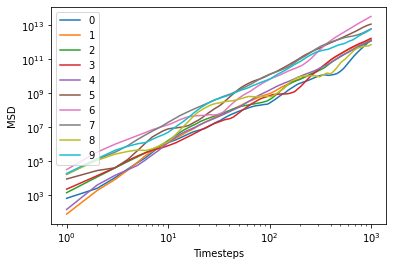

In [29]:
plot_MSD()

It works!!! Got some particles to selectively diffuse using per particle integrator!

## Try active Brownian integrator on an actual polymer simulation

Instead of the toy system with 10 particles and zero external forces, connect them via harmonic bonds, add repulsive interactions and a confinement, and see if I can still get differences in MSD.

In [7]:
_OPENMM_ENERGY_UNIT = unit.kilojoules_per_mole
#What is the monomer diffusion coefficient?
collision_rate = 2.0 * (1 / unit.picosecond)
conlen = 1.0 * unit.nanometer
mass = 100 * unit.amu
temperature = 300
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
kT = kB * temperature * unit.kelvin
kT / (mass * collision_rate)

Quantity(value=12.471693927229861, unit=picosecond*joule/(mole*dalton))

In [32]:
N=100
D = np.ones((N, 3))
D[0:50] = 0.25
D[50:] = 1.75
particleD = unit.Quantity(D,  kT / (mass * collision_rate))

reporter = HDF5Reporter(folder="simulations/test_integrator", max_data_length=100, overwrite=True)
collision_rate = 2.0 * (1 / unit.picosecond)
integrator = BrownianIntegrator(40*unit.femtosecond, collision_rate, particleD)
sim = simulation.Simulation(
    platform="CUDA", 
    integrator=integrator,
    error_tol=0.003,
    timestep=1,
    GPU="0",
    collision_rate=0.01,
    N=N,
    save_decimals=2,
    reporters=[reporter],
)
polymer = starting_conformations.grow_cubic(N, 5)

sim.set_data(polymer, center=True)  # loads a polymer, puts a center of mass at zero
sim.set_velocities(v=np.zeros((N,3)))
sim.add_force(forces.spherical_confinement(sim, density=0.224, k=5.0))
sim.add_force(
    forcekits.polymer_chains(
        sim,
        chains=[(0, None, False)],
        # By default the library assumes you have one polymer chain
        # If you want to make it a ring, or more than one chain, use self.setChains
        # self.setChains([(0,50,True),(50,None,False)]) will set a 50-monomer ring and a chain from monomer 50 to the end
        bond_force_func=forces.harmonic_bonds,
        bond_force_kwargs={
            "bondLength": 1.0,
            "bondWiggleDistance": 0.1,  # Bond distance will fluctuate +- 0.05 on average
        },
        angle_force_func=None,
        angle_force_kwargs={},
        nonbonded_force_func=forces.polynomial_repulsive,
        nonbonded_force_kwargs={
            "trunc": 3.0,  # this will let chains cross sometimes
            #'trunc':10.0, # this will resolve chain crossings and will not let chain cross anymore
        },
        except_bonds=True,
    )
)

ntimesteps = 1000
tic = time.perf_counter()
for _ in range(ntimesteps):  # Do 10 blocks
    sim.do_block(100)  # Of 100 timesteps each. Data is saved automatically. 
toc = time.perf_counter()
sim.print_stats()  # In the end, print very simple statistics
print(f'Ran simulation in {(toc - tic):0.4f}s')
reporter.dump_data()  # always need to run in the end to dump the block cache to the disk

INFO:root:Using the provided integrator object
INFO:root:adding force spherical_confinement 0
INFO:root:adding force harmonic_bonds 1
INFO:root:adding force polynomial_repulsive 2
INFO:root:Particles loaded. Potential energy is 0.000000
INFO:root:block    0 pos[1]=[-0.9 -1.1 -1.1] dr=0.40 t=4.0ps kin=48.11 pot=0.69 Rg=2.494 SPS=17522 
INFO:root:block    1 pos[1]=[-0.8 -1.1 -1.0] dr=0.41 t=8.0ps kin=35.64 pot=0.77 Rg=2.557 SPS=20342 
INFO:root:block    2 pos[1]=[-0.7 -1.3 -1.1] dr=0.38 t=12.0ps kin=43.88 pot=0.77 Rg=2.561 SPS=20130 
INFO:root:block    3 pos[1]=[-0.6 -1.2 -1.2] dr=0.41 t=16.0ps kin=38.25 pot=0.93 Rg=2.567 SPS=20740 
INFO:root:block    4 pos[1]=[-0.4 -1.3 -1.3] dr=0.40 t=20.0ps kin=43.02 pot=1.00 Rg=2.566 SPS=20607 
INFO:root:block    5 pos[1]=[-0.5 -1.4 -1.2] dr=0.41 t=24.0ps kin=38.82 pot=0.82 Rg=2.643 SPS=20144 
INFO:root:block    6 pos[1]=[-0.6 -1.5 -1.4] dr=0.39 t=28.0ps kin=40.20 pot=0.71 Rg=2.751 SPS=20588 
INFO:root:block    7 pos[1]=[-0.4 -1.4 -1.4] dr=0.41 t=32.

Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 99


INFO:root:block   19 pos[1]=[0.0 -1.2 -0.8] dr=0.43 t=80.0ps kin=38.94 pot=0.74 Rg=2.833 SPS=21047 
INFO:root:block   20 pos[1]=[-0.1 -1.1 -0.9] dr=0.44 t=84.0ps kin=40.25 pot=0.63 Rg=2.833 SPS=20780 
INFO:root:block   21 pos[1]=[0.1 -1.2 -0.6] dr=0.40 t=88.0ps kin=35.63 pot=0.90 Rg=2.850 SPS=20830 
INFO:root:block   22 pos[1]=[0.1 -1.2 -0.5] dr=0.43 t=92.0ps kin=41.39 pot=0.65 Rg=2.862 SPS=20689 
INFO:root:block   23 pos[1]=[0.2 -1.1 -0.4] dr=0.44 t=96.0ps kin=40.92 pot=0.75 Rg=2.916 SPS=21270 
INFO:root:block   24 pos[1]=[0.2 -1.1 -0.4] dr=0.44 t=100.0ps kin=35.56 pot=0.63 Rg=2.925 SPS=20785 
INFO:root:block   25 pos[1]=[-0.1 -1.0 -0.6] dr=0.40 t=104.0ps kin=47.32 pot=0.95 Rg=2.919 SPS=20695 
INFO:root:block   26 pos[1]=[-0.0 -0.9 -0.7] dr=0.43 t=108.0ps kin=39.88 pot=0.84 Rg=2.940 SPS=21121 
INFO:root:block   27 pos[1]=[-0.0 -0.9 -0.6] dr=0.44 t=112.0ps kin=32.44 pot=0.52 Rg=3.005 SPS=20684 
INFO:root:block   28 pos[1]=[-0.2 -0.9 -0.8] dr=0.40 t=116.0ps kin=43.69 pot=0.62 Rg=3.004 S

INFO:root:block  101 pos[1]=[1.3 -0.5 -2.6] dr=0.37 t=408.0ps kin=38.15 pot=0.60 Rg=3.296 SPS=24880 
INFO:root:block  102 pos[1]=[1.3 -0.6 -2.5] dr=0.38 t=412.0ps kin=38.66 pot=0.58 Rg=3.230 SPS=24434 
INFO:root:block  103 pos[1]=[1.5 -0.6 -2.4] dr=0.41 t=416.0ps kin=41.07 pot=0.51 Rg=3.239 SPS=26110 
INFO:root:block  104 pos[1]=[1.5 -0.6 -2.5] dr=0.40 t=420.0ps kin=27.81 pot=0.56 Rg=3.248 SPS=25265 
INFO:root:block  105 pos[1]=[1.4 -0.6 -2.3] dr=0.42 t=424.0ps kin=33.92 pot=0.61 Rg=3.269 SPS=24025 
INFO:root:block  106 pos[1]=[1.6 -0.6 -2.3] dr=0.45 t=428.0ps kin=38.70 pot=0.46 Rg=3.278 SPS=24521 
INFO:root:block  107 pos[1]=[1.3 -0.8 -2.4] dr=0.42 t=432.0ps kin=44.20 pot=0.84 Rg=3.338 SPS=24114 
INFO:root:block  108 pos[1]=[1.0 -0.9 -2.4] dr=0.43 t=436.0ps kin=39.42 pot=0.75 Rg=3.313 SPS=24558 
INFO:root:block  109 pos[1]=[1.0 -1.2 -2.6] dr=0.43 t=440.0ps kin=41.89 pot=0.86 Rg=3.393 SPS=24094 
INFO:root:block  110 pos[1]=[0.9 -1.4 -2.3] dr=0.39 t=444.0ps kin=40.11 pot=0.64 Rg=3.375 S

INFO:root:block  183 pos[1]=[2.2 -2.6 -2.8] dr=0.43 t=736.0ps kin=42.54 pot=0.57 Rg=3.375 SPS=26022 
INFO:root:block  184 pos[1]=[2.1 -2.6 -2.8] dr=0.44 t=740.0ps kin=38.32 pot=0.63 Rg=3.379 SPS=25746 
INFO:root:block  185 pos[1]=[2.1 -2.5 -2.7] dr=0.44 t=744.0ps kin=39.93 pot=0.77 Rg=3.347 SPS=24901 
INFO:root:block  186 pos[1]=[2.4 -2.3 -2.7] dr=0.45 t=748.0ps kin=32.95 pot=0.57 Rg=3.367 SPS=24783 
INFO:root:block  187 pos[1]=[2.3 -2.1 -2.5] dr=0.42 t=752.0ps kin=37.66 pot=0.62 Rg=3.371 SPS=24754 
INFO:root:block  188 pos[1]=[2.6 -1.9 -2.5] dr=0.44 t=756.0ps kin=43.64 pot=0.45 Rg=3.365 SPS=25045 
INFO:root:block  189 pos[1]=[2.7 -1.9 -2.4] dr=0.45 t=760.0ps kin=37.85 pot=0.54 Rg=3.360 SPS=25365 
INFO:root:block  190 pos[1]=[2.8 -2.1 -2.4] dr=0.48 t=764.0ps kin=41.12 pot=0.75 Rg=3.348 SPS=24544 
INFO:root:block  191 pos[1]=[2.9 -2.0 -2.7] dr=0.43 t=768.0ps kin=36.74 pot=0.77 Rg=3.329 SPS=24830 
INFO:root:block  192 pos[1]=[2.9 -2.2 -2.8] dr=0.43 t=772.0ps kin=36.14 pot=0.50 Rg=3.285 S

INFO:root:block  264 pos[1]=[2.2 -1.4 -1.5] dr=0.41 t=1060.0ps kin=37.89 pot=0.66 Rg=3.162 SPS=24960 
INFO:root:block  265 pos[1]=[2.0 -1.4 -1.6] dr=0.45 t=1064.0ps kin=45.75 pot=0.65 Rg=3.194 SPS=24691 
INFO:root:block  266 pos[1]=[2.2 -1.4 -1.4] dr=0.41 t=1068.0ps kin=39.75 pot=0.60 Rg=3.180 SPS=24134 
INFO:root:block  267 pos[1]=[2.4 -1.4 -1.4] dr=0.42 t=1072.0ps kin=35.78 pot=0.60 Rg=3.211 SPS=24613 
INFO:root:block  268 pos[1]=[2.3 -1.4 -1.3] dr=0.39 t=1076.0ps kin=33.92 pot=0.81 Rg=3.167 SPS=24147 
INFO:root:block  269 pos[1]=[2.7 -1.3 -1.5] dr=0.41 t=1080.0ps kin=41.58 pot=0.54 Rg=3.138 SPS=20133 
INFO:root:block  270 pos[1]=[2.5 -1.5 -1.7] dr=0.43 t=1084.0ps kin=47.43 pot=0.58 Rg=3.182 SPS=24342 
INFO:root:block  271 pos[1]=[2.4 -1.5 -1.6] dr=0.44 t=1088.0ps kin=38.20 pot=0.84 Rg=3.162 SPS=24482 
INFO:root:block  272 pos[1]=[2.7 -1.4 -1.5] dr=0.45 t=1092.0ps kin=43.23 pot=0.74 Rg=3.183 SPS=24865 
INFO:root:block  273 pos[1]=[2.6 -1.4 -1.5] dr=0.46 t=1096.0ps kin=38.94 pot=0.67 

INFO:root:block  345 pos[1]=[2.6 -1.9 -2.2] dr=0.46 t=1384.0ps kin=33.22 pot=0.55 Rg=3.399 SPS=25405 
INFO:root:block  346 pos[1]=[2.8 -1.9 -2.2] dr=0.43 t=1388.0ps kin=40.85 pot=0.84 Rg=3.419 SPS=24625 
INFO:root:block  347 pos[1]=[3.0 -2.0 -2.2] dr=0.42 t=1392.0ps kin=39.11 pot=0.58 Rg=3.452 SPS=25262 
INFO:root:block  348 pos[1]=[3.1 -1.8 -2.2] dr=0.41 t=1396.0ps kin=45.11 pot=0.68 Rg=3.416 SPS=24451 
INFO:root:block  349 pos[1]=[2.9 -2.0 -2.1] dr=0.46 t=1400.0ps kin=40.42 pot=0.60 Rg=3.365 SPS=25365 
INFO:root:block  350 pos[1]=[2.8 -2.0 -2.2] dr=0.39 t=1404.0ps kin=38.77 pot=0.80 Rg=3.365 SPS=25555 
INFO:root:block  351 pos[1]=[2.7 -2.0 -2.2] dr=0.38 t=1408.0ps kin=37.12 pot=0.67 Rg=3.362 SPS=25230 
INFO:root:block  352 pos[1]=[2.5 -2.0 -2.1] dr=0.40 t=1412.0ps kin=42.34 pot=0.82 Rg=3.392 SPS=25605 
INFO:root:block  353 pos[1]=[2.7 -2.2 -2.0] dr=0.40 t=1416.0ps kin=44.83 pot=0.79 Rg=3.459 SPS=25059 
INFO:root:block  354 pos[1]=[3.0 -2.2 -2.0] dr=0.44 t=1420.0ps kin=35.94 pot=0.82 

INFO:root:block  426 pos[1]=[3.2 -1.1 -2.9] dr=0.41 t=1708.0ps kin=38.01 pot=0.78 Rg=3.361 SPS=23857 
INFO:root:block  427 pos[1]=[3.2 -1.2 -2.9] dr=0.43 t=1712.0ps kin=39.54 pot=0.73 Rg=3.395 SPS=24451 
INFO:root:block  428 pos[1]=[3.2 -1.1 -2.7] dr=0.42 t=1716.0ps kin=40.88 pot=0.67 Rg=3.418 SPS=24814 
INFO:root:block  429 pos[1]=[3.1 -1.3 -2.7] dr=0.42 t=1720.0ps kin=46.22 pot=0.73 Rg=3.501 SPS=23707 
INFO:root:block  430 pos[1]=[3.0 -1.2 -2.5] dr=0.45 t=1724.0ps kin=34.00 pot=0.71 Rg=3.465 SPS=24837 
INFO:root:block  431 pos[1]=[3.3 -1.5 -2.5] dr=0.44 t=1728.0ps kin=41.63 pot=0.63 Rg=3.477 SPS=24093 
INFO:root:block  432 pos[1]=[3.1 -1.5 -2.7] dr=0.42 t=1732.0ps kin=44.67 pot=0.62 Rg=3.460 SPS=24693 
INFO:root:block  433 pos[1]=[3.1 -1.3 -2.6] dr=0.41 t=1736.0ps kin=40.71 pot=0.68 Rg=3.419 SPS=24710 
INFO:root:block  434 pos[1]=[3.0 -1.2 -2.7] dr=0.40 t=1740.0ps kin=43.84 pot=0.63 Rg=3.413 SPS=23914 
INFO:root:block  435 pos[1]=[2.8 -1.3 -2.8] dr=0.44 t=1744.0ps kin=36.08 pot=0.61 

INFO:root:block  507 pos[1]=[3.8 -1.8 -1.5] dr=0.38 t=2032.0ps kin=44.07 pot=0.50 Rg=3.286 SPS=24259 
INFO:root:block  508 pos[1]=[3.6 -1.6 -1.4] dr=0.39 t=2036.0ps kin=40.15 pot=0.62 Rg=3.255 SPS=24826 
INFO:root:block  509 pos[1]=[3.6 -1.6 -1.4] dr=0.48 t=2040.0ps kin=44.28 pot=0.72 Rg=3.246 SPS=24294 
INFO:root:block  510 pos[1]=[3.3 -1.5 -1.5] dr=0.47 t=2044.0ps kin=37.63 pot=0.98 Rg=3.256 SPS=24861 
INFO:root:block  511 pos[1]=[3.3 -1.4 -1.5] dr=0.44 t=2048.0ps kin=42.36 pot=0.64 Rg=3.273 SPS=24728 
INFO:root:block  512 pos[1]=[3.3 -1.4 -1.4] dr=0.39 t=2052.0ps kin=36.84 pot=0.88 Rg=3.283 SPS=24275 
INFO:root:block  513 pos[1]=[3.3 -1.3 -1.4] dr=0.36 t=2056.0ps kin=39.12 pot=0.78 Rg=3.251 SPS=24733 
INFO:root:block  514 pos[1]=[3.6 -1.3 -1.5] dr=0.46 t=2060.0ps kin=37.51 pot=0.53 Rg=3.222 SPS=24157 
INFO:root:block  515 pos[1]=[3.4 -1.2 -1.7] dr=0.39 t=2064.0ps kin=38.33 pot=0.59 Rg=3.228 SPS=24308 
INFO:root:block  516 pos[1]=[3.3 -1.4 -1.6] dr=0.44 t=2068.0ps kin=39.79 pot=0.81 

INFO:root:block  588 pos[1]=[3.9 -0.2 -1.2] dr=0.43 t=2356.0ps kin=39.41 pot=0.70 Rg=3.456 SPS=24530 
INFO:root:block  589 pos[1]=[3.9 0.0 -1.4] dr=0.47 t=2360.0ps kin=34.63 pot=0.55 Rg=3.464 SPS=24508 
INFO:root:block  590 pos[1]=[3.8 -0.0 -1.2] dr=0.42 t=2364.0ps kin=37.95 pot=0.71 Rg=3.439 SPS=25023 
INFO:root:block  591 pos[1]=[3.9 0.0 -1.0] dr=0.41 t=2368.0ps kin=36.37 pot=0.66 Rg=3.433 SPS=24956 
INFO:root:block  592 pos[1]=[3.8 -0.2 -0.9] dr=0.40 t=2372.0ps kin=41.03 pot=0.70 Rg=3.484 SPS=24225 
INFO:root:block  593 pos[1]=[3.9 -0.1 -0.9] dr=0.42 t=2376.0ps kin=38.37 pot=0.59 Rg=3.480 SPS=25066 
INFO:root:block  594 pos[1]=[3.8 -0.2 -1.1] dr=0.41 t=2380.0ps kin=42.62 pot=0.67 Rg=3.453 SPS=24229 
INFO:root:block  595 pos[1]=[3.9 -0.4 -1.1] dr=0.41 t=2384.0ps kin=43.59 pot=0.59 Rg=3.446 SPS=25135 
INFO:root:block  596 pos[1]=[3.9 -0.3 -1.3] dr=0.37 t=2388.0ps kin=45.47 pot=0.46 Rg=3.417 SPS=25319 
INFO:root:block  597 pos[1]=[4.1 -0.2 -1.1] dr=0.43 t=2392.0ps kin=37.09 pot=0.77 Rg

INFO:root:block  669 pos[1]=[2.3 -0.2 -1.5] dr=0.38 t=2680.0ps kin=39.14 pot=0.61 Rg=3.407 SPS=25708 
INFO:root:block  670 pos[1]=[2.2 -0.1 -1.3] dr=0.41 t=2684.0ps kin=39.00 pot=0.88 Rg=3.423 SPS=25188 
INFO:root:block  671 pos[1]=[2.1 0.0 -1.5] dr=0.40 t=2688.0ps kin=29.26 pot=0.52 Rg=3.391 SPS=25322 
INFO:root:block  672 pos[1]=[2.0 -0.1 -1.5] dr=0.39 t=2692.0ps kin=41.60 pot=0.60 Rg=3.388 SPS=24485 
INFO:root:block  673 pos[1]=[2.0 -0.0 -1.7] dr=0.40 t=2696.0ps kin=37.14 pot=0.72 Rg=3.403 SPS=24965 
INFO:root:block  674 pos[1]=[1.9 -0.1 -1.7] dr=0.41 t=2700.0ps kin=39.52 pot=0.52 Rg=3.426 SPS=24997 
INFO:root:block  675 pos[1]=[2.0 0.2 -1.8] dr=0.39 t=2704.0ps kin=33.94 pot=0.77 Rg=3.411 SPS=23958 
INFO:root:block  676 pos[1]=[2.1 0.3 -1.6] dr=0.41 t=2708.0ps kin=31.79 pot=0.78 Rg=3.426 SPS=25101 
INFO:root:block  677 pos[1]=[1.9 0.4 -1.5] dr=0.45 t=2712.0ps kin=34.27 pot=0.76 Rg=3.442 SPS=24049 
INFO:root:block  678 pos[1]=[1.9 0.4 -1.6] dr=0.42 t=2716.0ps kin=39.09 pot=0.65 Rg=3.

INFO:root:block  750 pos[1]=[2.3 -0.3 -3.9] dr=0.44 t=3004.0ps kin=40.55 pot=0.76 Rg=3.491 SPS=20957 
INFO:root:block  751 pos[1]=[2.2 -0.2 -3.9] dr=0.43 t=3008.0ps kin=34.45 pot=0.58 Rg=3.454 SPS=24577 
INFO:root:block  752 pos[1]=[1.9 0.1 -4.1] dr=0.43 t=3012.0ps kin=41.50 pot=0.70 Rg=3.443 SPS=24508 
INFO:root:block  753 pos[1]=[1.7 0.0 -4.1] dr=0.43 t=3016.0ps kin=37.14 pot=0.58 Rg=3.425 SPS=25655 
INFO:root:block  754 pos[1]=[1.8 0.0 -4.0] dr=0.42 t=3020.0ps kin=37.85 pot=0.51 Rg=3.414 SPS=25386 
INFO:root:block  755 pos[1]=[1.6 0.0 -4.0] dr=0.43 t=3024.0ps kin=32.21 pot=0.69 Rg=3.400 SPS=23613 
INFO:root:block  756 pos[1]=[1.5 -0.2 -3.7] dr=0.42 t=3028.0ps kin=31.66 pot=0.75 Rg=3.391 SPS=24367 
INFO:root:block  757 pos[1]=[1.6 0.0 -3.8] dr=0.41 t=3032.0ps kin=42.75 pot=0.83 Rg=3.432 SPS=23533 
INFO:root:block  758 pos[1]=[1.6 0.1 -3.7] dr=0.45 t=3036.0ps kin=35.51 pot=0.70 Rg=3.437 SPS=22647 
INFO:root:block  759 pos[1]=[1.9 0.1 -3.6] dr=0.36 t=3040.0ps kin=38.00 pot=0.57 Rg=3.45

INFO:root:block  831 pos[1]=[1.4 -0.8 -3.8] dr=0.41 t=3328.0ps kin=41.60 pot=0.57 Rg=3.350 SPS=24716 
INFO:root:block  832 pos[1]=[1.4 -0.8 -3.8] dr=0.42 t=3332.0ps kin=39.46 pot=0.61 Rg=3.354 SPS=24925 
INFO:root:block  833 pos[1]=[1.5 -0.9 -3.8] dr=0.42 t=3336.0ps kin=36.45 pot=0.55 Rg=3.380 SPS=24755 
INFO:root:block  834 pos[1]=[1.4 -1.0 -3.5] dr=0.40 t=3340.0ps kin=31.52 pot=0.53 Rg=3.362 SPS=25066 
INFO:root:block  835 pos[1]=[1.4 -1.0 -3.5] dr=0.41 t=3344.0ps kin=36.30 pot=0.56 Rg=3.353 SPS=24540 
INFO:root:block  836 pos[1]=[1.5 -1.3 -3.5] dr=0.46 t=3348.0ps kin=37.57 pot=0.72 Rg=3.328 SPS=25339 
INFO:root:block  837 pos[1]=[1.4 -1.1 -3.5] dr=0.43 t=3352.0ps kin=43.46 pot=0.71 Rg=3.348 SPS=25810 
INFO:root:block  838 pos[1]=[1.3 -1.2 -3.4] dr=0.43 t=3356.0ps kin=41.62 pot=0.68 Rg=3.368 SPS=24270 
INFO:root:block  839 pos[1]=[1.3 -1.3 -3.6] dr=0.41 t=3360.0ps kin=35.78 pot=0.77 Rg=3.368 SPS=24757 
INFO:root:block  840 pos[1]=[1.3 -1.7 -3.4] dr=0.42 t=3364.0ps kin=34.40 pot=0.68 

INFO:root:block  912 pos[1]=[1.6 -1.5 -3.7] dr=0.45 t=3652.0ps kin=36.22 pot=1.00 Rg=3.422 SPS=24717 
INFO:root:block  913 pos[1]=[2.0 -1.2 -4.0] dr=0.43 t=3656.0ps kin=35.84 pot=0.78 Rg=3.443 SPS=23667 
INFO:root:block  914 pos[1]=[1.9 -1.1 -4.0] dr=0.42 t=3660.0ps kin=38.25 pot=0.68 Rg=3.460 SPS=24649 
INFO:root:block  915 pos[1]=[1.8 -1.1 -4.1] dr=0.47 t=3664.0ps kin=39.36 pot=0.40 Rg=3.455 SPS=18105 
INFO:root:block  916 pos[1]=[1.9 -1.0 -4.1] dr=0.40 t=3668.0ps kin=39.17 pot=0.80 Rg=3.489 SPS=24444 
INFO:root:block  917 pos[1]=[1.9 -1.1 -3.9] dr=0.41 t=3672.0ps kin=46.19 pot=0.60 Rg=3.496 SPS=24738 
INFO:root:block  918 pos[1]=[1.5 -1.2 -4.0] dr=0.42 t=3676.0ps kin=32.78 pot=0.75 Rg=3.537 SPS=24534 
INFO:root:block  919 pos[1]=[1.6 -1.2 -4.0] dr=0.39 t=3680.0ps kin=44.74 pot=0.49 Rg=3.561 SPS=22641 
INFO:root:block  920 pos[1]=[1.8 -1.2 -4.0] dr=0.43 t=3684.0ps kin=31.08 pot=0.68 Rg=3.516 SPS=24726 
INFO:root:block  921 pos[1]=[1.9 -1.2 -3.8] dr=0.47 t=3688.0ps kin=40.15 pot=0.72 

INFO:root:block  993 pos[1]=[2.2 -0.4 -2.2] dr=0.42 t=3976.0ps kin=38.85 pot=0.61 Rg=3.277 SPS=23749 
INFO:root:block  994 pos[1]=[2.0 -0.3 -2.1] dr=0.42 t=3980.0ps kin=39.53 pot=0.55 Rg=3.343 SPS=24190 
INFO:root:block  995 pos[1]=[2.2 -0.4 -2.0] dr=0.38 t=3984.0ps kin=38.18 pot=0.63 Rg=3.354 SPS=24764 
INFO:root:block  996 pos[1]=[2.0 -0.3 -1.9] dr=0.40 t=3988.0ps kin=42.04 pot=0.78 Rg=3.343 SPS=23754 
INFO:root:block  997 pos[1]=[1.9 -0.3 -2.0] dr=0.46 t=3992.0ps kin=36.06 pot=0.73 Rg=3.331 SPS=24371 
INFO:root:block  998 pos[1]=[1.9 -0.5 -2.0] dr=0.44 t=3996.0ps kin=39.54 pot=0.57 Rg=3.297 SPS=24120 
INFO:root:block  999 pos[1]=[1.9 -0.8 -2.2] dr=0.40 t=4000.0ps kin=45.53 pot=0.87 Rg=3.352 SPS=24364 



 Statistics: number of particles: 100

Statistics for particle position
     mean position is:  [-0.12967826 -0.00437849 -0.14340652]   Rg =  3.352149
     median bond size is  0.9967752122646539
     three shortest/longest (<10)/ bonds are  [0.87975524 0.8917929  0.89987201]    [1.22199337 1.25316087 1.25460295]
     95 percentile of distance to center is:    4.424061596309149
     density of closest 95% monomers is:    0.2619217120824207
     density of the 5% closest to CoM monomers is:    0.31295768059487555
     min/median/mean/max coordinates are: 
     x: -3.90, -0.65, -0.13, 3.77
     y: -4.24, -0.06, -0.00, 3.62
     z: -3.61, -0.25, -0.14, 3.60

Statistics for velocities:
     mean kinetic energy is:  45.531947958695135 should be: 1.5
     fastest particles are (in kT):  [152.00788548 216.81135415 225.0758125  230.3806877  282.24618566]

Statistics for the system:
     Forces are:  ['spherical_confinement', 'harmonic_bonds', 'polynomial_repulsive']

Potential Energy Ep =  0.

In [24]:
def plot_MSD_ave(datadir):
    starting_pos = load_hdf5_file(Path(datadir)/"starting_conformation_0.h5")['pos']
    #check that only members of force group 1 moved
    data = list_URIs(datadir)
    dxs = []
    prev_pos = starting_pos
    for conformation in data:
        pos = load_URI(conformation)['pos']
        dx_squared = np.sum((pos - starting_pos)**2, axis=-1)
        dxs.append(dx_squared)

    dxs = np.array(dxs)
    times = np.arange(1, ntimesteps + 1)
    plt.plot(times, np.mean(dxs[:, 0:50], axis=1), label='cold')
    plt.plot(times, np.mean(dxs[:, 50:], axis=1), label='hot')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Timesteps')
    plt.ylabel('MSD')

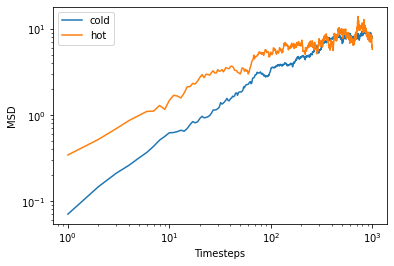

In [30]:
plot_MSD_ave("simulations/test_integrator")

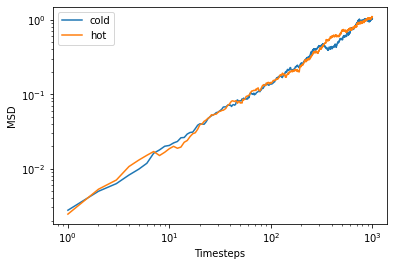

In [26]:
plot_MSD_ave("simulations/self-avoidance")

In [39]:
1.75/.25

7.0